# QAOA Based Energy Efficient Satellite Task Scheduling Under Orbital Visibility Constraints
 Satellite task sheduling involves assigning observation or communication tasks to satellite while respecting orbital  visibility window , limited onboard energy and missin priorities .Due to dynamic nature od satellite orbit , a task can only be executed when the target is visisble to thr satellite,making the scheduling problem highly constrained and comninatorial using **QAOA (Quantum Approximation Optimization Algorithm)**.
 ### Goal of project:
 - Ensures tasks are executed only within valid orbital visisbility windows
 - Minimizes energy usage os satellite
 - Maximize the number of successfully scheduled tasks
 - Demonstrates the applicability od quantum algorithm ro real world aerospace optimization problems

## Why a Quantum(QAOA) Solution ?
Classical optimization methoda struggle with satellite schedulling because the problem is NP-hard , and the solution space grow exponentially with the number of satellite and tasks.QAOA leverages quantum superposition and interfernece to explore many possible schedule simulteneously enabling:
- faster covergence to near-optimal solution 
- Better scalability for large combinatiorial problems
- Improve solutionquality for complex construct driven optimization.
Thus QAOA Provides a Promising  alternatives to classical heuristic for solving large scale ,energy efficient  satellite sheduling problem.

## Import Required Libraries

In [ ]:
from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector,SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt


## Problem Definition (Same as classical)
The problem consider a simplified satellite task scheduling scenario where a fixed set of tasks is defined as input  to a QAOA -based optimization framwork,At this stage, no optimization,constraints or quantum opearion are applied.The task information is only initialized and stored in a structured format for later use.Each task is charecterized by:
- A Each task identifier.
- Energy consumption required for execution.
- Priority level indicating task importance.
- Orbital visibility window  during which the task can be executed.

We consider a satellite task scheduling problem where each task is represented by a binary decision variable.
$$
x_i \in \{0,1\},\quad i \in \{1,2,3,4\}
$$

where 
- $ x_i=1 \rightarrow $ Task  $ T_i $ is scheduled.
- $ x_i=0 \rightarrow $ Task  $ T_i $ is  not scheduled.

### Given Task Parameters
| Task | Energy Cost $ E_i $ | Priority Weight $ P_i $ | Visibility Window |
| ---- | ---- | ----| ---- |
| T1 | 2 | 3(High) | W1 |
| T2 | 1 | 2(Medium) | W1 |
| T3 | 3 | 3(High) | W2 |
| T4 | 2 | 1(Medium) | W3 |

### optimization objective
$$
\min \;  \text{Energy} \quad \text{while satisfying visibility and priority constraints}
$$




In [68]:
tasks=["T1","T2","T3","T4"]
energy_cost=[2,1,3,2] # T1,T2,T3,T4
priority=[3,2,3,1] # High,medium,low
energy_budget=5
visibility = ['W1','W1','W2','W3']
#visibility conflicts: T1 & T2(indices 0 and 1)
num_tasks=len(tasks)
print("\n tasks:",tasks)


 tasks: ['T1', 'T2', 'T3', 'T4']


## Cost Hamiltonian (Energy/Priority)
This step construct  the **cost hamiltonian** using task energy and priority values. the hamiltonian is designed to assign a cost each task inedependently,without introduction any interaction term between tasks.
### Input Paramaters
- 'Energy': a list of energy costs for each task
$$
\text{energy}=[E_1,E_2,E_3,E_4]
$$
- 'priority' : a list of priority weights for each task
$$ 
\text{priority}=[P_1,P_2,P_3,P_4]
$$

## Pauli-Z Operator Construction
for each task index $ i $ ,a pauli string is constructed as follows:
1. A Pauli string of length $ n $ (number of tasks) is initilized with **identity operators**:
$$
Z\_string^{(i)}=I\otimes I\otimes \cdots \otimes I
$$
2. Identity opeartor at position $i$ is replaced with a **Pauli-Z operators**
$$
Z\_string^{(i)}=I\otimes \cdots \otimes  Z_i \otimes \cdots \otimes I
$$
3. A coefficent is assigned to this pauli string using the energy and priority values of the corrosponding task:
$$
c_i=\frac{E_i}{P_i}
$$
4.the pauli string and its coefficient are appended to the hamiltonian.

---

### Mathematical Formulation
The resuliting cost Hamiltonian is a weighted sum of single-qubit Pauli-Z opeartors:
$$
H_{\text{cost}}=\sum_{i=1}^{n}\frac{E_i}{P_i}\,Z_i
$$
Where:
- $ n\ $ is the total number of tasks
- $ Z_i \ $ acts on qubit $ i $ and identity acts on all other qubits

---
### Sparse Pauli representation
The hamiltonion is returened as a **Sparse Pauli Opeartor**,which efficiently stores:
- The Pauli-z strings
-Their corrosponding coefficient $$ \frac{E_i}{P_i} $$
This representation is directly compatible with QAOA cost layers on Qiskit

In [70]:

#cost=sum(energy_i/priority_i*Z_i)
def cost_hamiltonian(energy,priority):
    #cost=sum(energy_i/priority_i*Z_i)
    pauli_term=[]
    coeff=[]
    for i in range(len(energy)):
        z_string=['I']*len(energy)
        z_string[i]='Z'
        pauli_term.append(''.join(z_string))
        coeff.append(energy[i]/priority[i])
    return SparsePauliOp(pauli_term,coeff)


## Build Cost Hamiltonian Layer
This step implements the **cost hamiltionian evolution layer** of QAOA by applying parametrized single qubit phase rotation to te quantum circuit .the layer encodes energy and priority information directly into the quantum State using state Z-axis rotations.
### Input Parameters
The function receive:
- qc: the quantum circuit
- y (gamma) : QAOA cost parameter
- energy : energy list of above
- priority : list of task 

### operation perform
1. A rotation angle is computed as:
$$ 
\theta_i =\gamma\cdot (E_i\cdot P_i)
$$
2. A Z-axis rotation is applied to qubit $ i $ with twice this angle:
$$
R_Z=(2\theta_i)=R_Z\big(2\gamma E_i P_i\big)
$$

This rotation introduced phase shift proprotional to te task's energy and priority.

---

### Mathematical interpretation:
the applied unitary corrosponds to:
$$
U_C(\gamma) =\prod_{i=1}^{n} e^{-i\gamma (E_i P_i) Z_i}
$$
Where:
- $ Z_i $ is the Pauli-Z opeartor acting on qubit $ i $
- Each task constribute independently  to the cost evolution
for circuit level representation :
for each qubit $ i $
$$
|\psi \rangle \rightarrow R_Z\big(2\gamma E_i P_i\big)_i |\psi \rangle
$$
This layer strictly follow the parametrized define in the code and does not include visibility or energy panalty constraints.

In [71]:
def cost_layer(qc,gamma,energy,priority):
    for i in range(len(energy)):
        angle=gamma*(energy[i] * priority[i])
        qc.rz(2*angle,i)


## Visibility Panalty Layer
this step implements the **visibility panalty layer** to discourage selecting multiple tasks that share the same orbita visibility window,The panalty is applied using conditional two qubit operations whenever two task have indentical visibility window.
### Input Parameter
- qc : Quantum circuit
- y(gamma): QAOA cost parameter
- visibility : W1,W2.....
- panalty : a fixed scaler value (default =2.0)

---

### Mathematical Interpretation
the applied opeartion correspond to the unitary:
$$
U_{\text{vis}}\gamma = 
\exp-(-i\gamma \cdot \text{penalty} \cdot Z_i Z_j )\quad \text{ if }W_i=W_j
$$
This introduces an additional phase cost when both qubits are in the $ |1\rangle $ state ,panalizing simultaneous selection of tasks with overlapping visibility.

In [72]:
def visibility_panalty_layer(qc,gamma,visibility,panalty=2.0):
    for i in range(len(visibility)):
        for j in range (i+1,len(visibility)):
            if visibility[i]==visibility[j]:
                qc.cx(i,j)
                qc.rz(2*gamma*panalty,j)
                qc.cx(i,j)

## Energy Panalty
this layer adds a **penalty for high-energy tasks** to encourage energy-efficient scheduling in the QAOA circuit.

### Input Parameters
- qc: Quantum Circuit
- y(gamma) :QAOA cost parameter
- energy : list of energy as above
- threshold :Energy threshold above which a panalty is applied (default =3)
- panalty_strength: scaler multiplier for panalty (10 in code)

### Mathematical formulation
the corresponding unitary for high -energy task is:
$$
U_{\text{energy}}(\gamma)=\prod_{i: E_i > \text{threshold}}\exp(-i\gamma\cdot Z_i)
$$
where:
- $ Z_i $ is the pauli Z opeartor acting on qubit $ i $
- only task with energy above the threshold contribute

In [82]:
"""def energy_panalty(qc,gamma,panalty=10):
    from itertools import combinations

    for r in range(2,n_qubits+1):
        for combo in combinations(range(n_qubits),r):
            total_energy= sum(energy_cost[i] for i in combo)
            if total_energy>energy_budget: 
                ctrl=combo[:-1]
                target=combo[-1]

            
            qc.mcx(ctrl,target)
            qc.rz(2*gamma*panalty,target)
            qc.mcx(ctrl,target)"""

panalty_strength=10
def energy_panalty_layer(qc,gamma,energy,threshold=3):
    for i in range(len(energy)):
        if energy[i]>threshold:
            qc.rz(2*gamma*energy[i],i)

## Mixer Layer
The mixer layer allows the QAOA algorithm to **explore the solution space** by rotating qubits around the X-axis .This prevents the algorithm getting stuck in local minima and ensure better coverage of possible task shedules.
### Input Parameters
- qc: Quantum circuit
- B(beta):QAOA mixer parameter
- num_qubits: number od qubits

### Mathematical formulation
$$
U_M(\beta) =\prod_{i=1}^{n} \exp(-i\beta X_i)
$$
where:
- $ n $ = number of qubits
- $ X_i $ is the pauli -X opeartor acting on qubit $ i $ 

In [83]:
def mixer_layer(qc,beta,num_qubits):
    for i in range(num_qubits):
        qc.rx(2*beta,i)

## Build Full QAOA circuit
### mathematical formulation
$$
|\psi\boldsymbol{\gamma},\boldsymbol{\beta}\rangle=
\prod_{l=1}^{p}
U_M\beta_l\,U_{\text{energy}}\gamma_l\,U_{\text{vis}}\gamma_l\,U_C\gamma_l
\,|+\rangle^{\otimes n}
$$
where:
- $ U_c\gamma_l=\ $ cost hamiltonian layer
- $ U_{\text{vis}}\gamma_l=\ $ visibility panalty layer
- $ U_{\text{energy}}\gamma_l=\ $ energy panalty layer
- $ U_M\beta_l=\ $ mixer layer

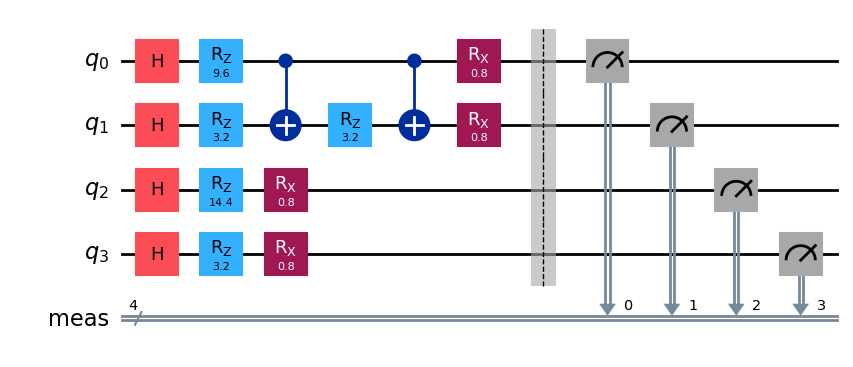

In [84]:
def build_qaoa_circuit(p,energy,priority,visibility,gammas,betas):
    qc=QuantumCircuit(num_tasks)

    # Initial state b|+>
    qc.h(range(num_tasks))

    # cost +panalty
    for layer in range(p):
        gamma=gammas[layer]
        beta=betas[layer]
        cost_layer(qc,gamma,energy,priority)
        visibility_panalty_layer(qc,gamma,visibility)
        energy_panalty_layer(qc,gamma,energy)
        mixer_layer(qc,beta,num_tasks)
   
   
    qc.measure_all()
    return qc
p=1
gammas=[0.8]
betas=[0.4]
qaoa_circuit=build_qaoa_circuit(p=p,
                                energy=energy_cost,
                                priority=priority,
                                visibility=visibility,
                                gammas=gammas,
                                betas=betas)
qaoa_circuit.draw('mpl')


## Run AerSimulator

In [85]:
from qiskit import transpile
sim=AerSimulator()
compiled=transpile(qaoa_circuit,sim)
result=sim.run(compiled,shots=1024).result()
counts=result.get_counts()
counts


{'1100': 23,
 '0011': 103,
 '1011': 103,
 '0010': 117,
 '0100': 32,
 '0001': 101,
 '1001': 88,
 '1010': 106,
 '1000': 131,
 '1111': 19,
 '0000': 127,
 '0110': 15,
 '1110': 15,
 '0111': 13,
 '0101': 17,
 '1101': 14}

## Extract Probabilities

In [86]:
probabilities={k:v/1024 for k,v in counts.items()}
probabilities

{'1100': 0.0224609375,
 '0011': 0.1005859375,
 '1011': 0.1005859375,
 '0010': 0.1142578125,
 '0100': 0.03125,
 '0001': 0.0986328125,
 '1001': 0.0859375,
 '1010': 0.103515625,
 '1000': 0.1279296875,
 '1111': 0.0185546875,
 '0000': 0.1240234375,
 '0110': 0.0146484375,
 '1110': 0.0146484375,
 '0111': 0.0126953125,
 '0101': 0.0166015625,
 '1101': 0.013671875}

## Plot Distribution

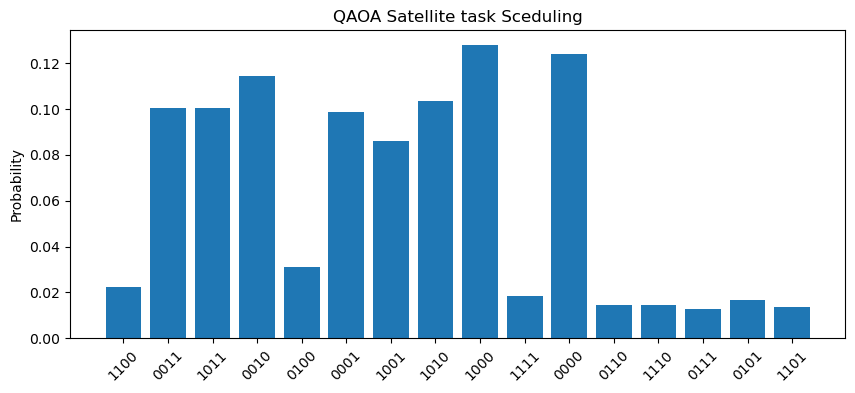

In [87]:
plt.figure(figsize=(10,4))
plt.bar(probabilities.keys(),probabilities.values())
plt.xticks(rotation=45)
plt.ylabel("Probability")
plt.title("QAOA Satellite task Sceduling")
plt.show()

## Extract Best Quantum Schedule

In [88]:
best_state=max(probabilities,key=probabilities.get)
best_state

'1000'

In [89]:
selected_tasks=[]
for i,bit in enumerate(reversed(best_state)):
    if bit=="1":
        selected_tasks.append(tasks[i])
selected_tasks

['T4']

### Why T4?
- Energy/Priority ratio is largest : 2/1 =2 --> cost hamiltonian roteas T4 qubit the most.
- No visibility conflicts: T4 is in W3 --> Safe from panalties
- Energy panalty /threshold: T4 energy =2 threshild--> no extra panalty

so the T4 naturally dominates the probability distribution --> circuit "chooses" is as the most important task.

## Classical Style Visulalization


### How this acheive our goal
- our objective was energy-efficient scheduling with priority
- T4 has high priority (priority=1 is most important" according to our setup) and mederates energy --> the algorithm recogizes is as the best task to schedule  alone.
- The most exactly what QAOA is designed to do: amplify low cost,high-priority solution.
- The result indicates that T4 in indeed the most valuable task under the constraints ,which validates that our cost hamiltonian + panalties+QAOA layers are working correctly.

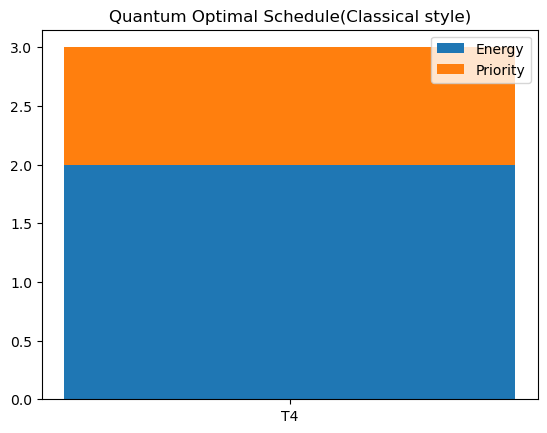

In [90]:
selected_energy=[energy_cost[tasks.index(t)] for t in selected_tasks]
selected_priority=[priority[tasks.index(t)] for t in selected_tasks]

x=np.arange(len(selected_tasks))
plt.bar(x,selected_energy,label="Energy")
plt.bar(x,selected_priority,bottom=selected_energy,label="Priority")
plt.xticks(x,selected_tasks)
plt.legend()
plt.title("Quantum Optimal Schedule(Classical style)")
plt.show()

**Author** : Shreya Sunil Palase

**Repository**: Quantum-Computing-coding(codeQubit)

**Project** : QAOA Based Energy Efficient Satellite task Scheduling under Orbital Visibility Constraint

**file** : QAOA_satellite_schedular.ipynb(Day3)

**Date created**: 1-Janaury-2026

<sub>© Shreya Palase- All Rights Reserved.This notbook is part of a structured learning series designed for Github publication.</sub>